In [2]:
import numpy as np
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform

In [3]:
####### Load Dataset #######
def load_images(folder_path):
    images = [] 
    labels = []

    i = 0
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = io.imread(img_path)
        img = transform.resize(img, (64, 64), anti_aliasing=True)
        images.append(img)
        labels.append(int(filename.split("_")[1]))
    
    return np.array(images), np.array(labels)

faces, labels = load_images('./dataset')

In [4]:
####### Print information about the dataset #######
print(f"Number of samples: {faces.shape[0]}")
print(f"Number of features (pixels): {faces.shape[1]}")
print(f"Number of unique labels (people): {len(set(labels))}")

Number of samples: 400
Number of features (pixels): 64
Number of unique labels (people): 40


In [5]:
####### Prepare Dataset #######
X_train, X_test, y_train, y_test = train_test_split(faces, labels, test_size=0.2, random_state=42, stratify=labels)

X_train_reshaped = X_train.reshape(X_train.shape[0], -1) #[[1,2,3][1,2,3][1,2,3]] => [1,2,3,1,2,3,1,2,3]
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [6]:
####### PCA #######
n_components = 150
pca = PCA(n_components=n_components, whiten=True).fit(X_train_reshaped)

X_train_pca = pca.transform(X_train_reshaped)
X_test_pca = pca.transform(X_test_reshaped)

In [7]:
####### Decision Tree #######
# Train
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_pca, y_train)

# Cross-validation with K fold (cv) = 5
decision_tree_cv_scores = cross_val_score(decision_tree_classifier, X_train_pca, y_train, cv=5)
print(f"Decision Tree Cross-Validation Scores: {decision_tree_cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(decision_tree_cv_scores):.2f}")

# Predict
y_pred_tree = decision_tree_classifier.predict(X_test_pca)

# Evaluate
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Decision Tree Accuracy: {accuracy_tree:.2f}")

Decision Tree Cross-Validation Scores: [0.34375  0.359375 0.375    0.4375   0.421875]
Mean Cross-Validation Score: 0.39
Decision Tree Accuracy: 0.54


In [8]:
####### Random Forest #######
# Train
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_train_pca, y_train)

# Cross-validation
random_forest_cv_scores = cross_val_score(random_forest_classifier, X_train_pca, y_train, cv=5)
print(f"Random Forest Cross-Validation Scores: {random_forest_cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(random_forest_cv_scores):.2f}")


# Predict
y_pred_forest = random_forest_classifier.predict(X_test_pca)

# Evaluate
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print(f"Random Forest Accuracy: {accuracy_forest:.2f}")

Random Forest Cross-Validation Scores: [0.875    0.859375 0.875    0.84375  0.859375]
Mean Cross-Validation Score: 0.86
Random Forest Accuracy: 0.94


In [9]:
####### Tuned Random Forest #######
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and retrain the model
best_params = grid_search.best_params_
best_forest_classifier = RandomForestClassifier(random_state=42, **best_params)
best_forest_classifier.fit(X_train_pca, y_train)

# Cross-validation
best_forest_cv_scores = cross_val_score(best_forest_classifier, X_train_pca, y_train, cv=5)
print(f"Tuned Random Forest Cross-Validation Scores: {best_forest_cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(best_forest_cv_scores):.2f}")

# Predict
y_pred_best_forest = best_forest_classifier.predict(X_test_pca)

# Evaluate
accuracy_best_forest = accuracy_score(y_test, y_pred_best_forest)
print(f"Tuned Random Forest Accuracy: {accuracy_best_forest:.2f}")


Tuned Random Forest Cross-Validation Scores: [0.90625  0.890625 0.921875 0.890625 0.921875]
Mean Cross-Validation Score: 0.91
Tuned Random Forest Accuracy: 0.93


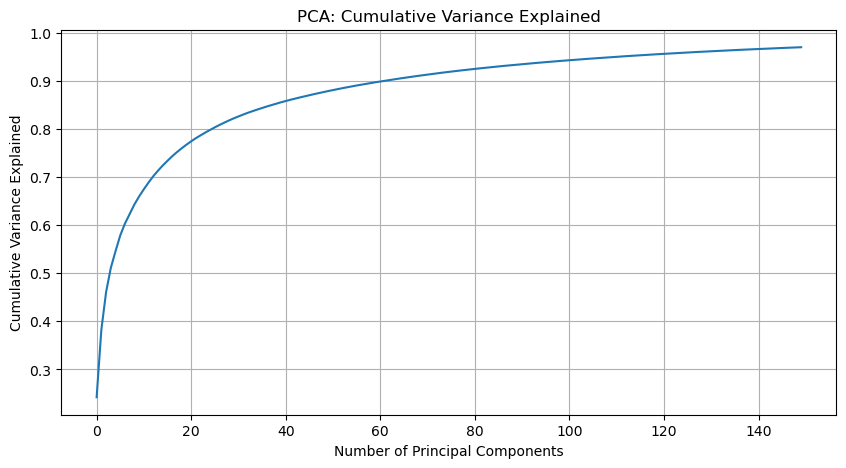

In [10]:
####### Cumulative Variance Plot #######
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA: Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

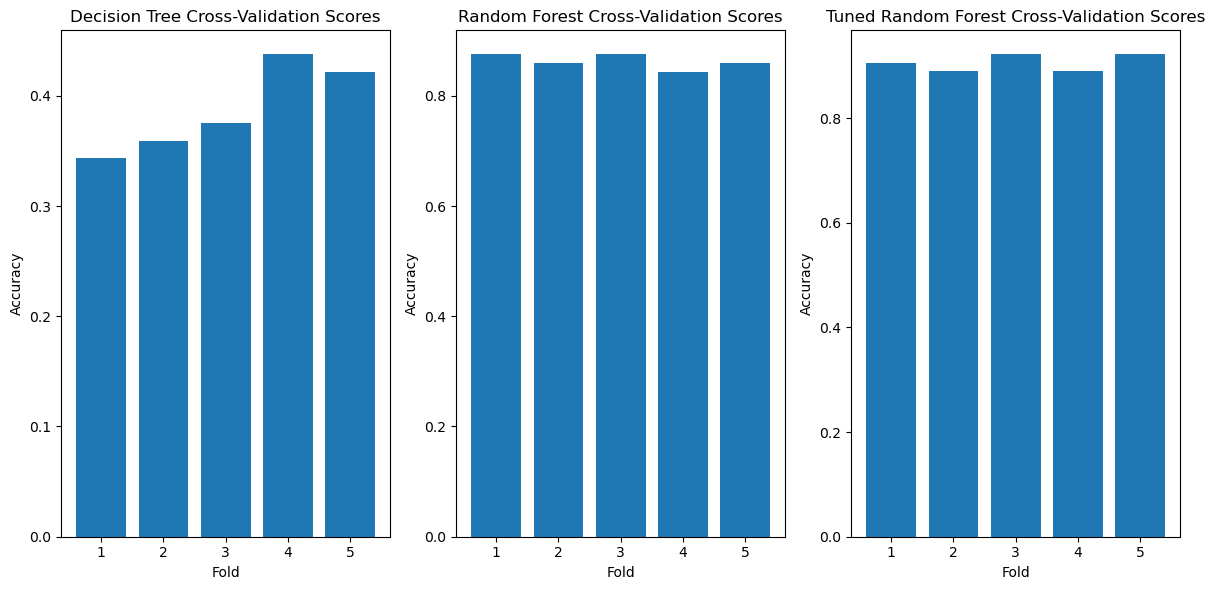

In [11]:
####### Cross-Validation Scores Plots #######
plt.figure(figsize=(12, 6))

# Plot Decision Tree Cross-Validation Scores
plt.subplot(1, 3, 1)
plt.bar(range(1, 6), decision_tree_cv_scores)
plt.title('Decision Tree Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Plot Random Forest Cross-Validation Scores
plt.subplot(1, 3, 2)
plt.bar(range(1, 6), random_forest_cv_scores)
plt.title('Random Forest Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Plot Tuned Random Forest Cross-Validation Scores
plt.subplot(1, 3, 3)
plt.bar(range(1, 6), best_forest_cv_scores)
plt.title('Tuned Random Forest Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


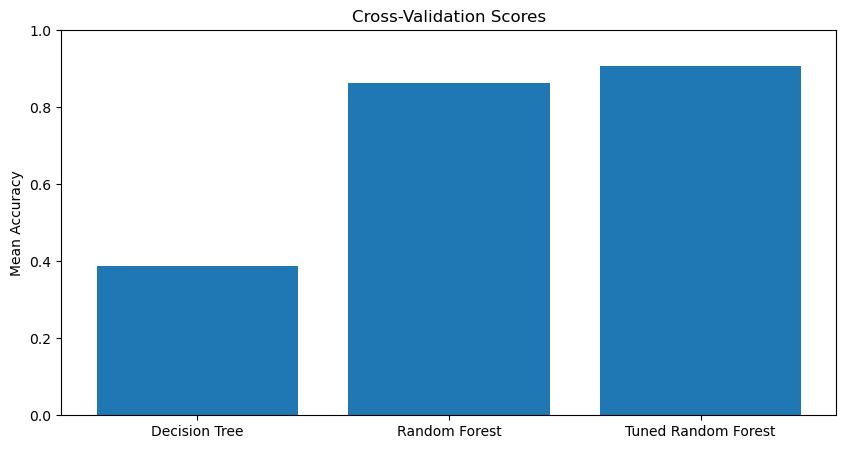

In [12]:
####### CV scores - Mean Accuracy Plot #######
plt.figure(figsize=(10, 5))
plt.bar(['Decision Tree', 'Random Forest', 'Tuned Random Forest'], [np.mean(decision_tree_cv_scores), np.mean(random_forest_cv_scores), np.mean(best_forest_cv_scores)])
plt.title('Cross-Validation Scores')
plt.ylim(0, 1)
plt.ylabel('Mean Accuracy')
plt.show()

In [13]:
####### Results Table #######
results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Tuned Random Forest'],
    'Accuracy': [accuracy_tree, accuracy_forest, accuracy_best_forest],
    'Mean Cross-Validation Score': [np.mean(decision_tree_cv_scores), np.mean(random_forest_cv_scores), np.mean(best_forest_cv_scores)]
})

print("Testing Results:")
print(results_df)


Testing Results:
                 Model  Accuracy  Mean Cross-Validation Score
0        Decision Tree    0.5375                      0.38750
1        Random Forest    0.9375                      0.86250
2  Tuned Random Forest    0.9250                      0.90625


In [14]:
####### Function to predict an image using the tuned random forest model #######
def predict_person(image_path, pca_model = pca, classifier_model = best_forest_classifier):
    img = io.imread(image_path)
    img = transform.resize(img, (64, 64), anti_aliasing=True)
    img_reshaped = img.reshape(1, -1)

    img_pca = pca_model.transform(img_reshaped)

    prediction = classifier_model.predict(img_pca)

    return prediction[0]

In [15]:
####### GUI #######
import customtkinter
from PIL import ImageTk, Image
import tkinter

#Window Theme
customtkinter.set_appearance_mode("System")
customtkinter.set_default_color_theme("dark-blue")

#Starting Window
app=customtkinter.CTk()

#Window Dimensions
w = 800
h = 500
ws = app.winfo_screenwidth()
hs = app.winfo_screenheight()
x = (ws/2) - (w/2)
y = (hs/2) - (h/2)
app.geometry('%dx%d+%d+%d' % (w, h, x, y))
app.title("Face Recognition Project")

#Insert Label
First_Label = customtkinter.CTkLabel(app,text="Upload Your Image",text_color="Green",font=("segoe ui",18))
First_Label.pack(pady=10)

#Upload The Image Function
def upload_the_image():
    global image_label
    # Remove old image_label if it exists
    if 'image_label' in globals():
        image_label.pack_forget()

    imported_image = tkinter.filedialog.askopenfilename(initialdir="/Pictures",
    title="Select Your Image Please", filetypes=(("all file", "*.*"), ("png files", "*.*"),))

    label.configure(text= "Person " + str(predict_person(imported_image, pca, best_forest_classifier)))

    #image
    # Load the image using PIL
    try:
        image = Image.open(imported_image)
        resized_image = image.resize((230, 300), Image.ANTIALIAS)
        # Convert the image for Tkinter
        tk_image = ImageTk.PhotoImage(resized_image)
        # Create a label to display the image
        image_label = tkinter.Label(app, image=tk_image)
        image_label.pack()
        # Keep a reference to the image to prevent garbage collection
        image_label.image = tk_image
    except FileNotFoundError:
        print("File not found. Please provide a valid path to your image file.")
    except Exception as e:
        print("An error occurred while loading the image:", e)

#Import Button
import_button = customtkinter.CTkButton(app,text="Import Image",command=upload_the_image)
import_button.pack()

#Result Image
label = customtkinter.CTkLabel(app,text="",text_color="Green" ,font=("segoe ui",18))
label.pack(pady=20)

#Loop Window 
app.mainloop()

/tmp/ipykernel_7792/3381025253.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((230, 300), Image.ANTIALIAS)
/tmp/ipykernel_7792/3381025253.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((230, 300), Image.ANTIALIAS)
/tmp/ipykernel_7792/3381025253.py:43: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((230, 300), Image.ANTIALIAS)
